# This notebook contains the code necessary to evaluate and visualise the predictions of a single model. 
# **Instructions**: Run all cells and enter the number corresponding to your model of choice when prompted.

In [6]:
from tqdm import tqdm
import os
import time
from datetime import datetime
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import re
import warnings
from time import sleep

warnings.simplefilter("ignore")


/home/incomple_/Term6/3D_Brain_Tumor_Seg_V2/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from utils.Meter import dice_coef_metric_per_classes, jaccard_coef_metric_per_classes

from utils.BratsDataset import BratsDataset

from utils.Meter import BCEDiceLoss

from utils.viz_eval_utils import get_dataloaders, compute_scores_per_classes, count_parameters

from models.UNet3d import UNet3d
from models.UNet3dSingleConv import UNet3dSingleConv
from models.UNet3dDropout import UNet3dDropout
from models.SwinUNETR import SwinUNETR
from models.UNet3d_SELU import UNet3d_SELU
from models.UNet3d_atten import UNet3d_atten
from models.ONet3d import ONet3d
from models.ONet3d_v2 import ONet3d_v2
from models.ONet3d_v3 import ONet3d_v3
from models.ONet3d_v3_DoubleConv import ONet3d_v3_DoubleConv
from models.UNet3d_GELU import UNet3d_GELU
from models.ONet3d_v3_GELU import ONet3d_v3_GELU
from models.SphereNet3d import SphereNet3d



## Create a dictionary which maps the model names/directories in the Logs folder to their respective model initialisations.

In [12]:
modelDict = {
    "3DOnet_DoubleConv_Kernel1": ONet3d_v3_DoubleConv(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel1": ONet3d_v3(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel1_32_Channels": ONet3d_v3(in_channels=4, n_classes=3, n_channels=32).to('cuda'),
    "3DOnet_SingleConv_Kernel1_GELU": ONet3d_v3_GELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel1_GELU_AdamW": ONet3d_v3_GELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel3": ONet3d_v2(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel5": ONet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet": UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_32_Channels": UNet3d(in_channels=4, n_classes=3, n_channels=32).to('cuda'),
    "3DUnet_Atten": UNet3d_atten(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_Dropout": UNet3dDropout(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_GELU": UNet3d_GELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_SELU": UNet3d_SELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_SingleConv": UNet3dSingleConv(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "SphereNet3D": SphereNet3d(in_channels=4, n_classes=3, n_channels=16).to('cuda'),
    "SwinUNETR": SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(1, 1, 1, 1), num_heads=(2, 4, 8, 16)).to('cuda'),
    "SwinUNETR_AdamW": SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(1, 1, 1, 1), num_heads=(2, 4, 8, 16)).to('cuda'),
    "SwinUNETR_DoubleLayerDepth": SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(2, 2, 2, 2), num_heads=(2, 4, 8, 16)).to('cuda'),
}


## Define function which takes in a numerical user input and outputs a string representation of the chosen model.

In [13]:
def chooseModel():
    availableActions = {str(i+1): k for (i, k)
                        in zip(range(len(modelDict)), modelDict.keys())}
    nl = '\n'
    # Takes in a dictionary with key/value pair corresponding with control/action
    availableActionsList = [(key, val)
                            for key, val in availableActions.items()]
    print(f"Use number keys to choose one of the models below: \n")
    print(
        f"Available Models: {nl.join(f'[{tup[0]}: {tup[1]}]' for tup in availableActionsList)}")
    sleep(1)
    while True:
        userInput = input("Enter your action: ")
        if userInput not in availableActions:
            print(
                f"{userInput} is an invalid action. Please try again.")
        else:
            break
    return availableActions[userInput]


# chooseModel()


#  Run this cell to Evaluate and visualise predictions for a single model. Model is selected by inputting a number when prompted.

Use number keys to choose one of the models below: 

Available Models: [1: 3DOnet_DoubleConv_Kernel1]
[2: 3DOnet_SingleConv_Kernel1]
[3: 3DOnet_SingleConv_Kernel1_32_Channels]
[4: 3DOnet_SingleConv_Kernel1_GELU]
[5: 3DOnet_SingleConv_Kernel1_GELU_AdamW]
[6: 3DOnet_SingleConv_Kernel3]
[7: 3DOnet_SingleConv_Kernel5]
[8: 3DUnet]
[9: 3DUnet_32_Channels]
[10: 3DUnet_Atten]
[11: 3DUnet_Dropout]
[12: 3DUnet_GELU]
[13: 3DUnet_SELU]
[14: 3DUnet_SingleConv]
[15: SphereNet3D]
[16: SwinUNETR]
[17: SwinUNETR_AdamW]
[18: SwinUNETR_DoubleLayerDepth]
'3DOnet_SingleConv_Kernel1_GELU_AdamW' selected for evaluation and visualisation
3DOnet_SingleConv_Kernel1_GELU_AdamW loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_GELU_AdamW/your_best_model_20230317-181323.pth. parameters: 3150435
Evaluating on test set...


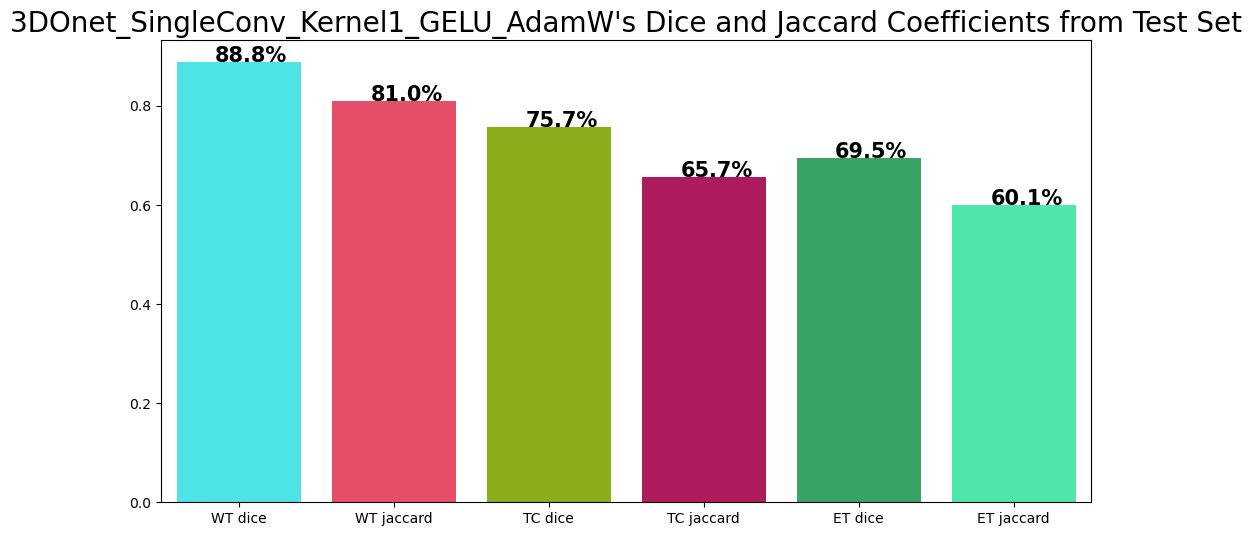

Evaluation done! Inference time: 0:00:26.992066.  Now proceeding to visualisation of predictions...
Target found:  BraTS20_Training_004
Predicting for:  3DOnet_SingleConv_Kernel1_GELU_AdamW


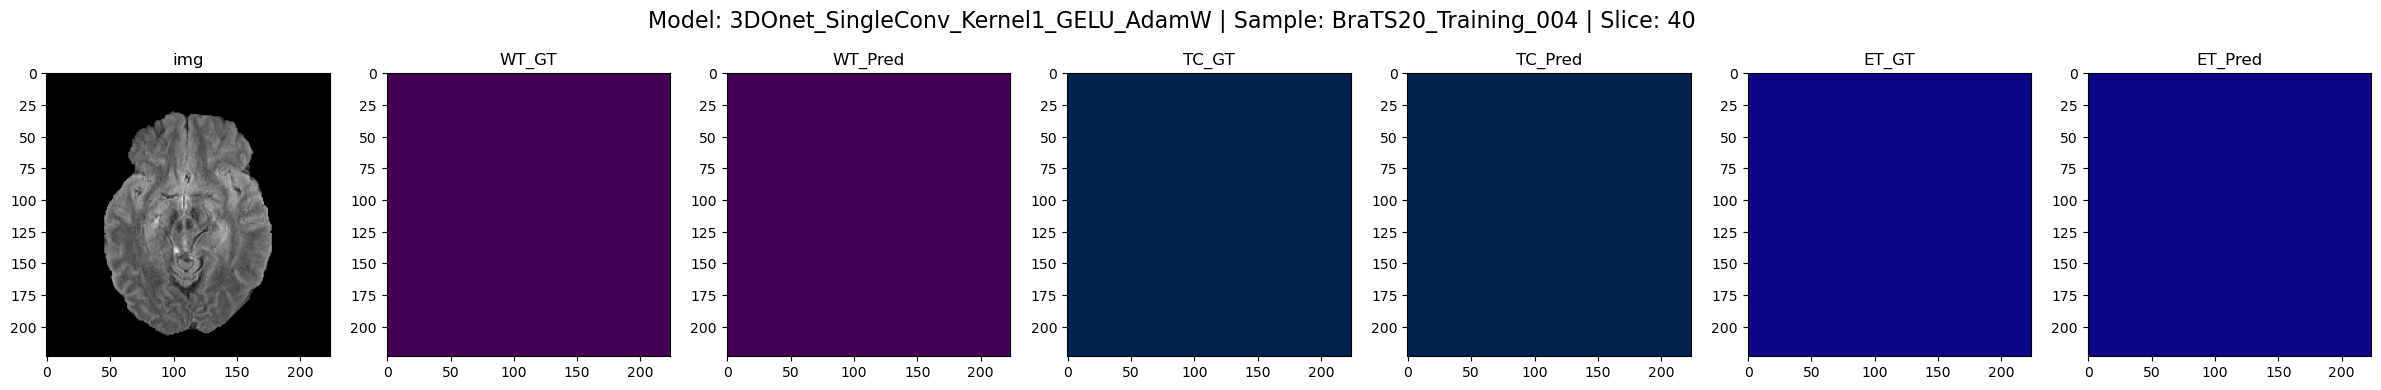

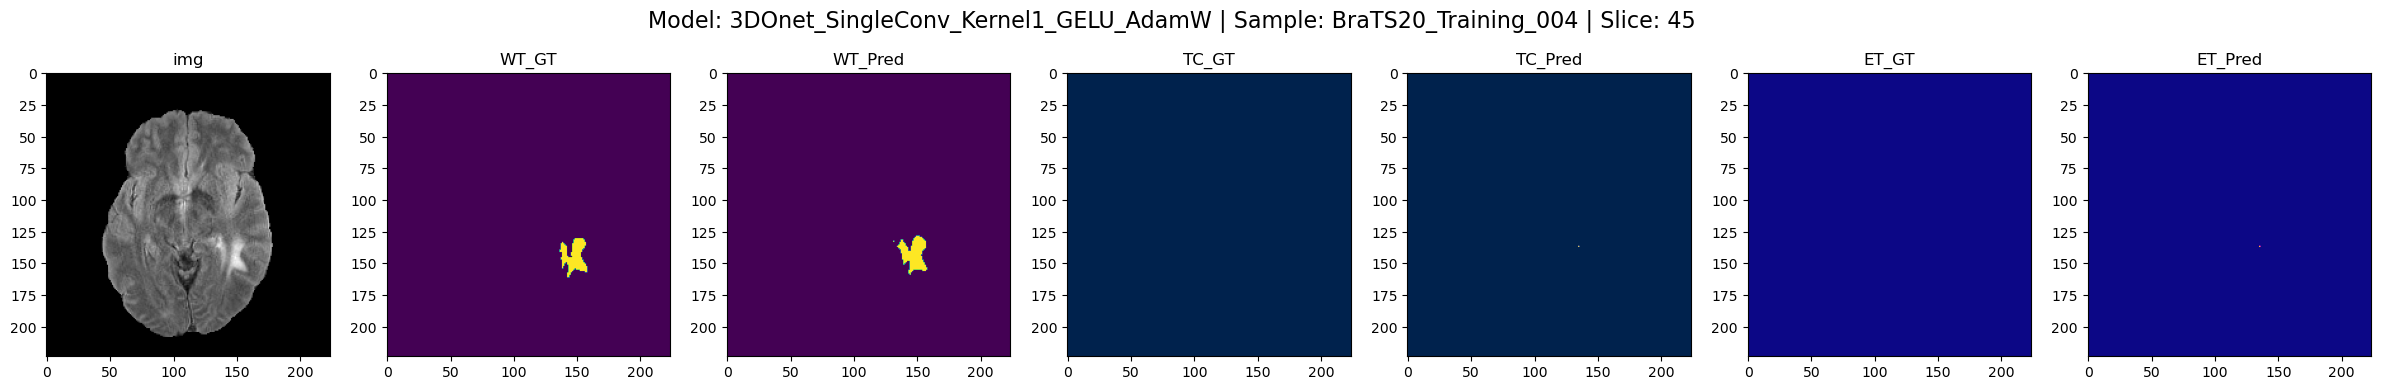

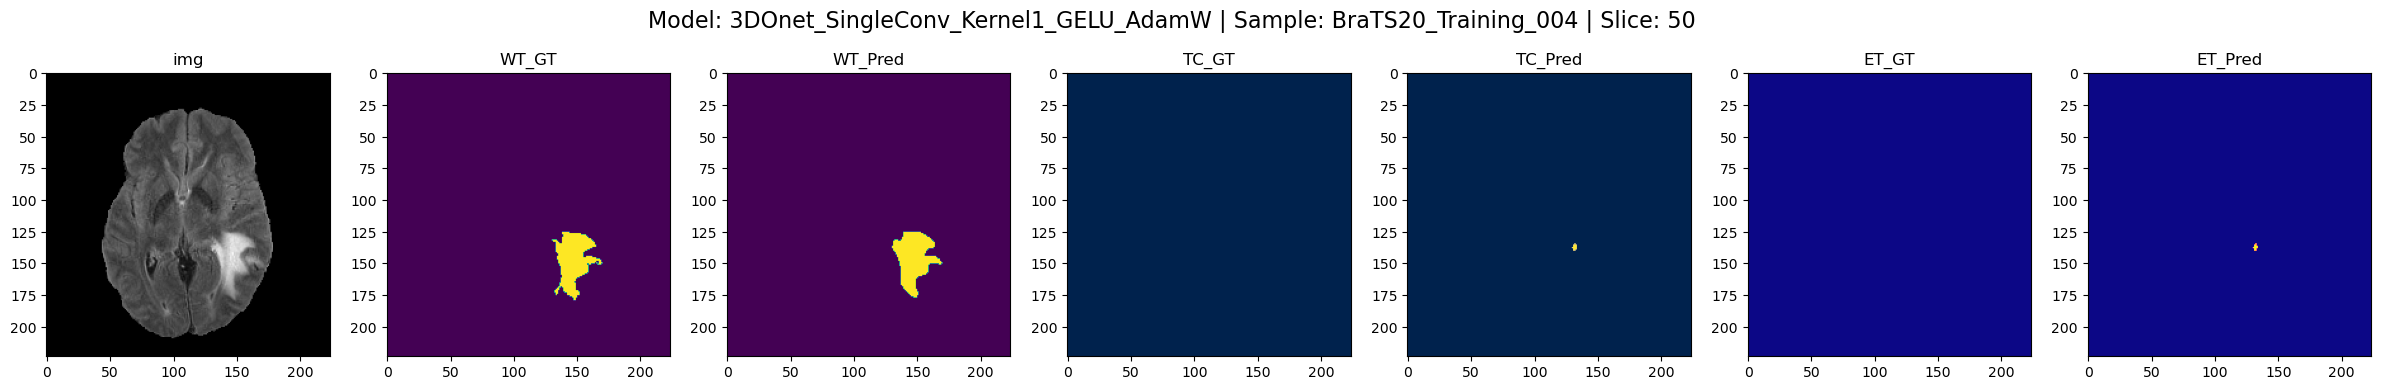

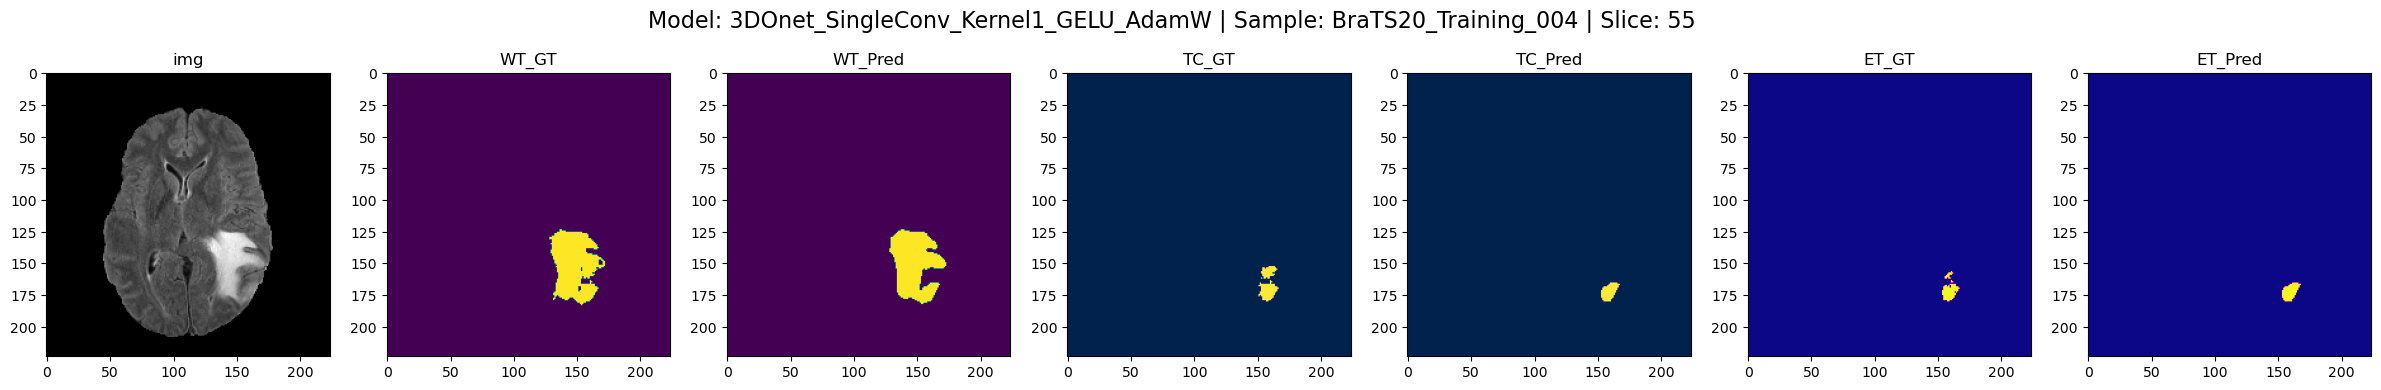

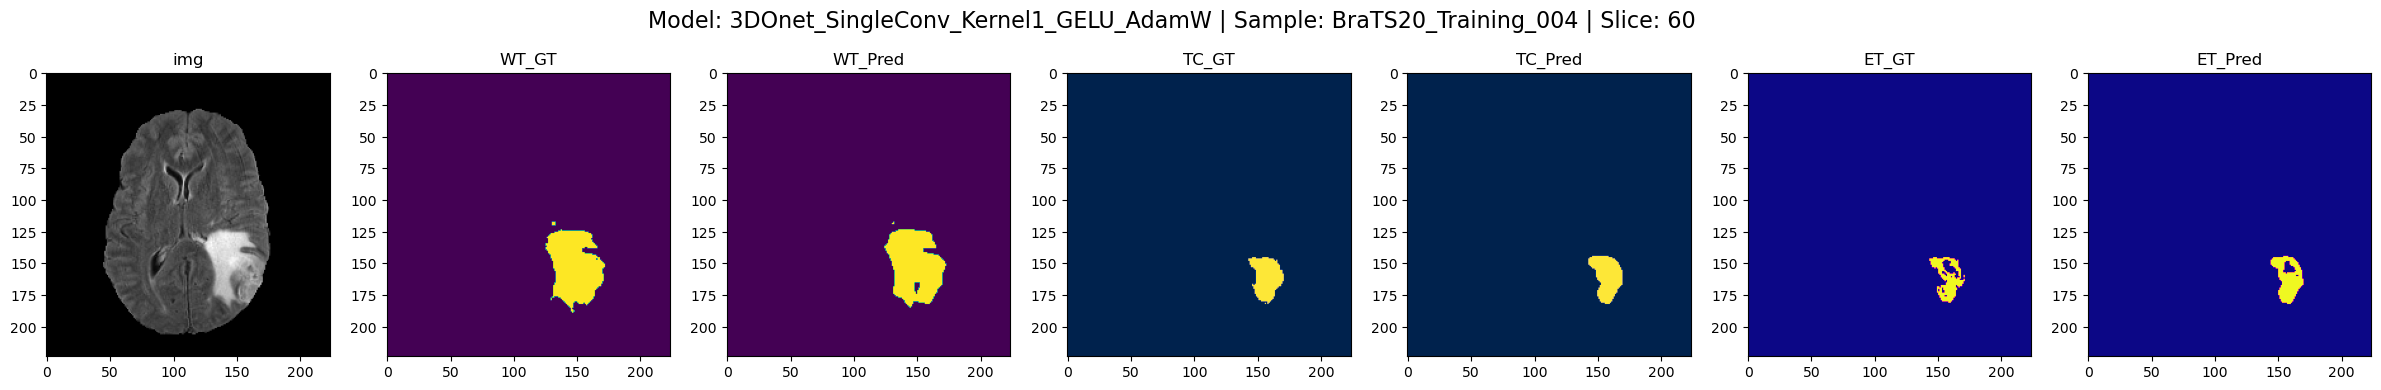

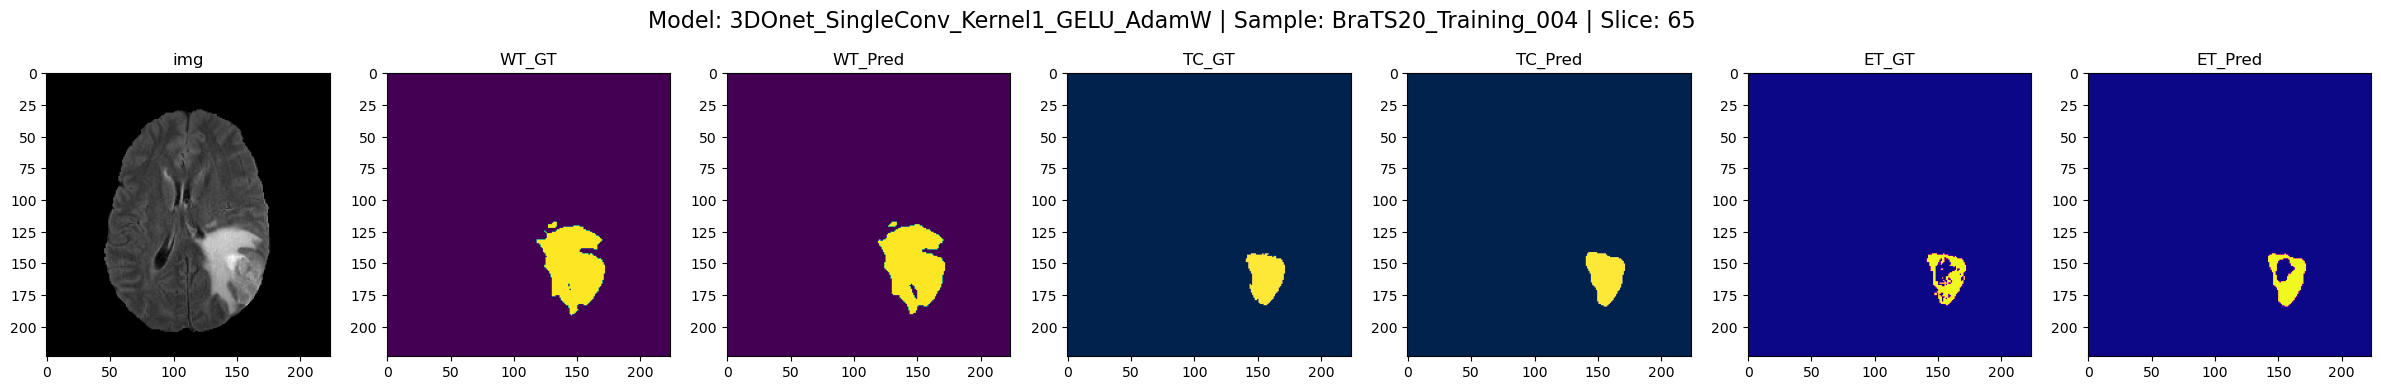

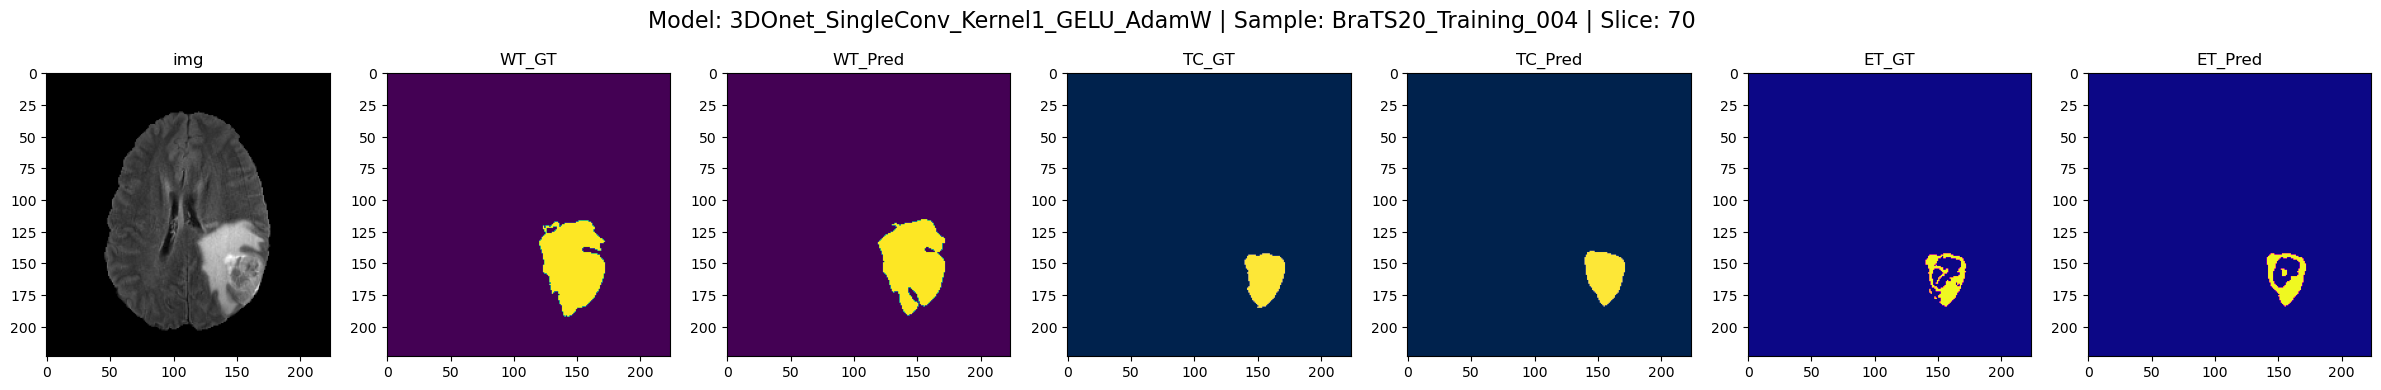

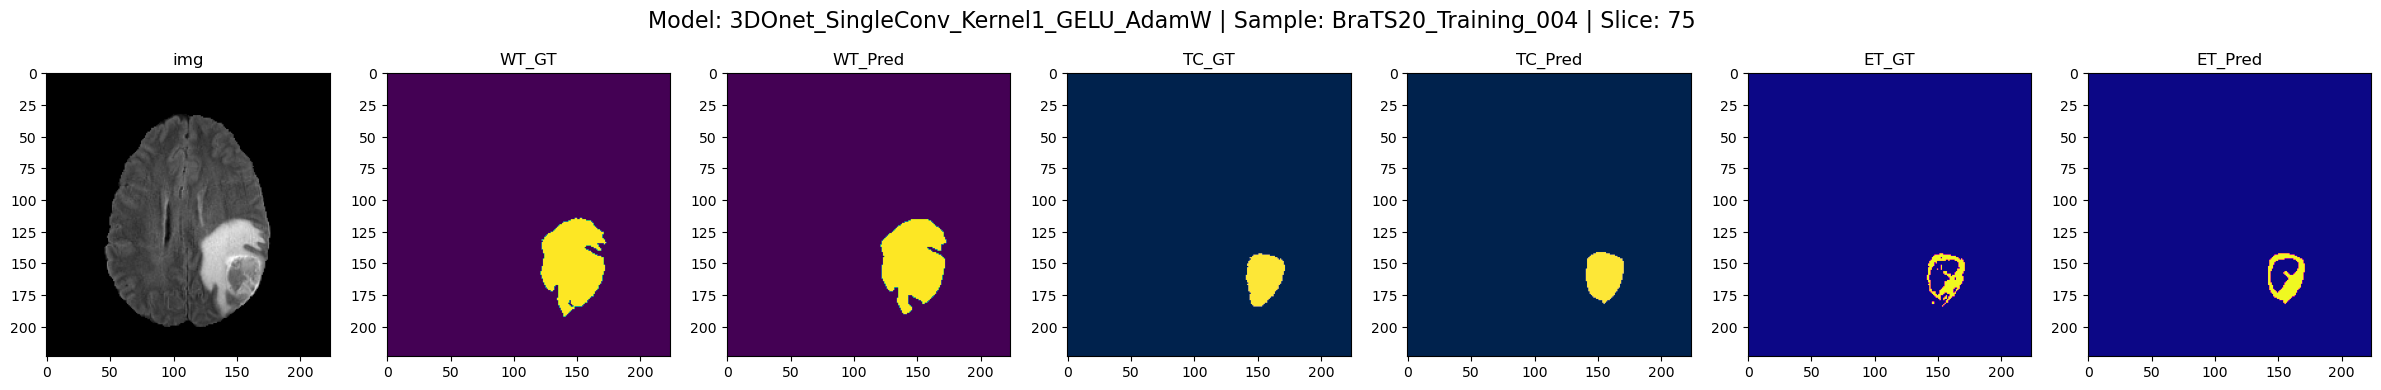

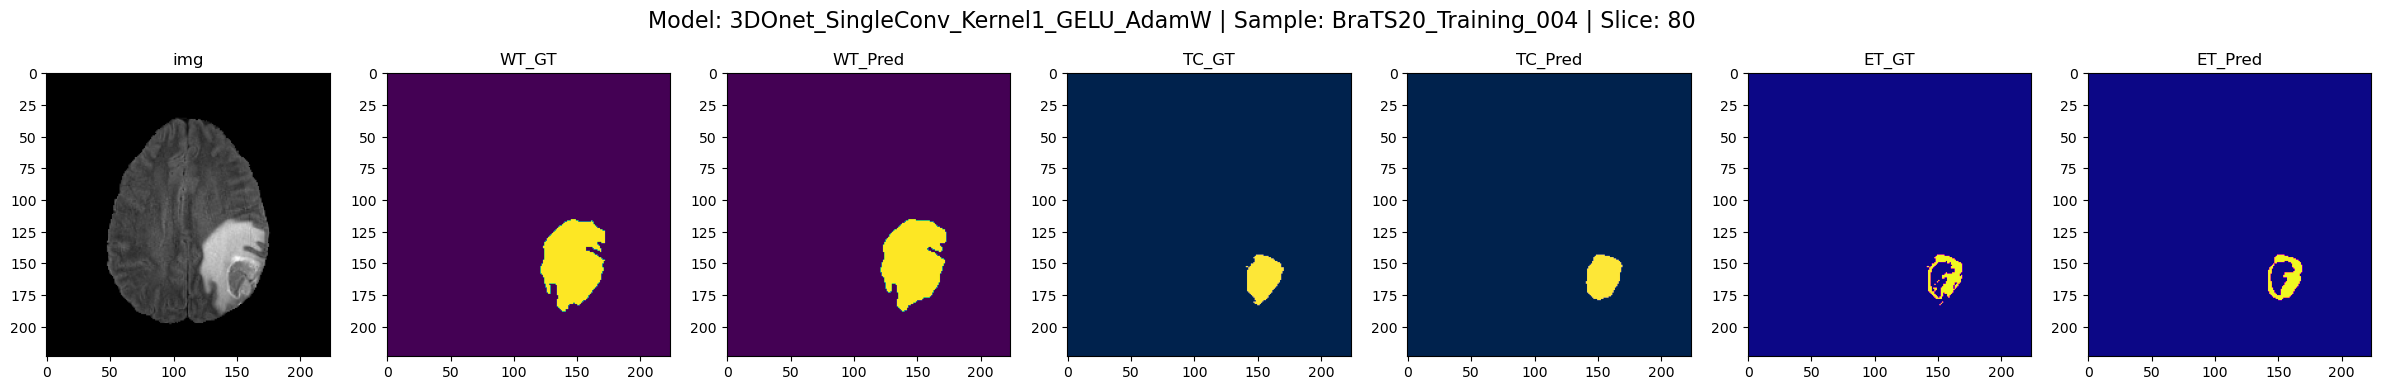

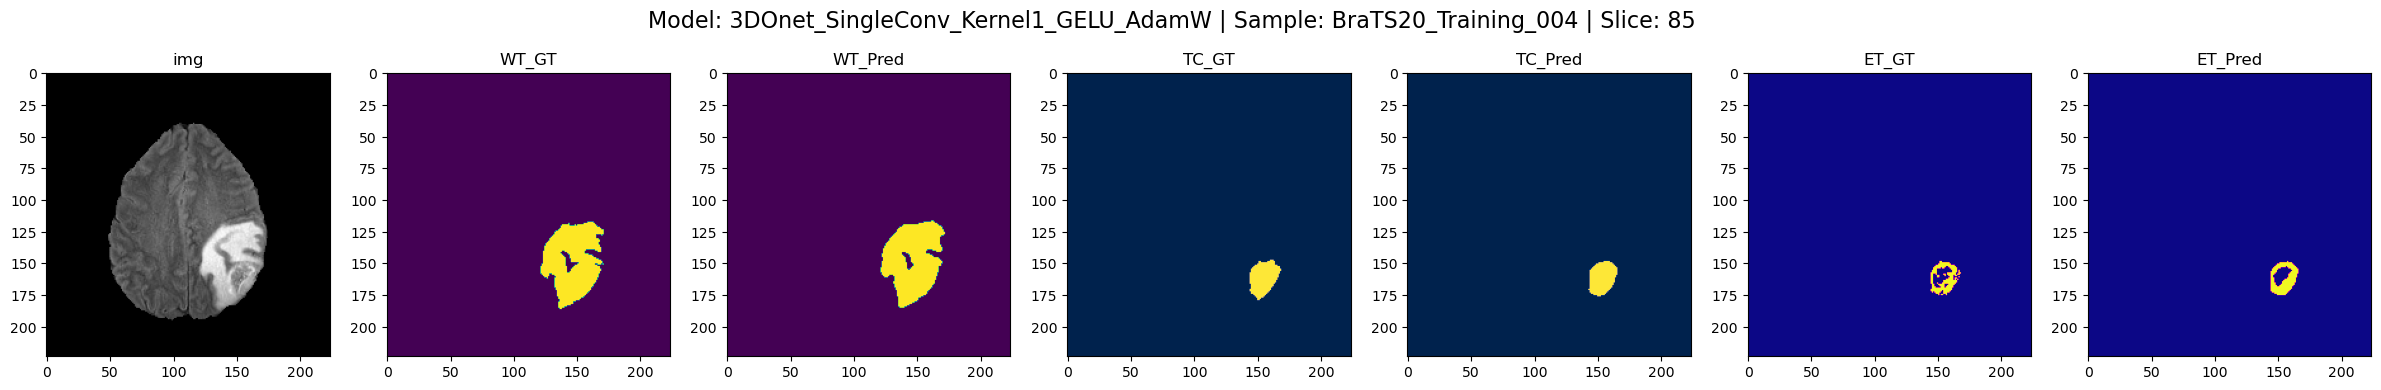

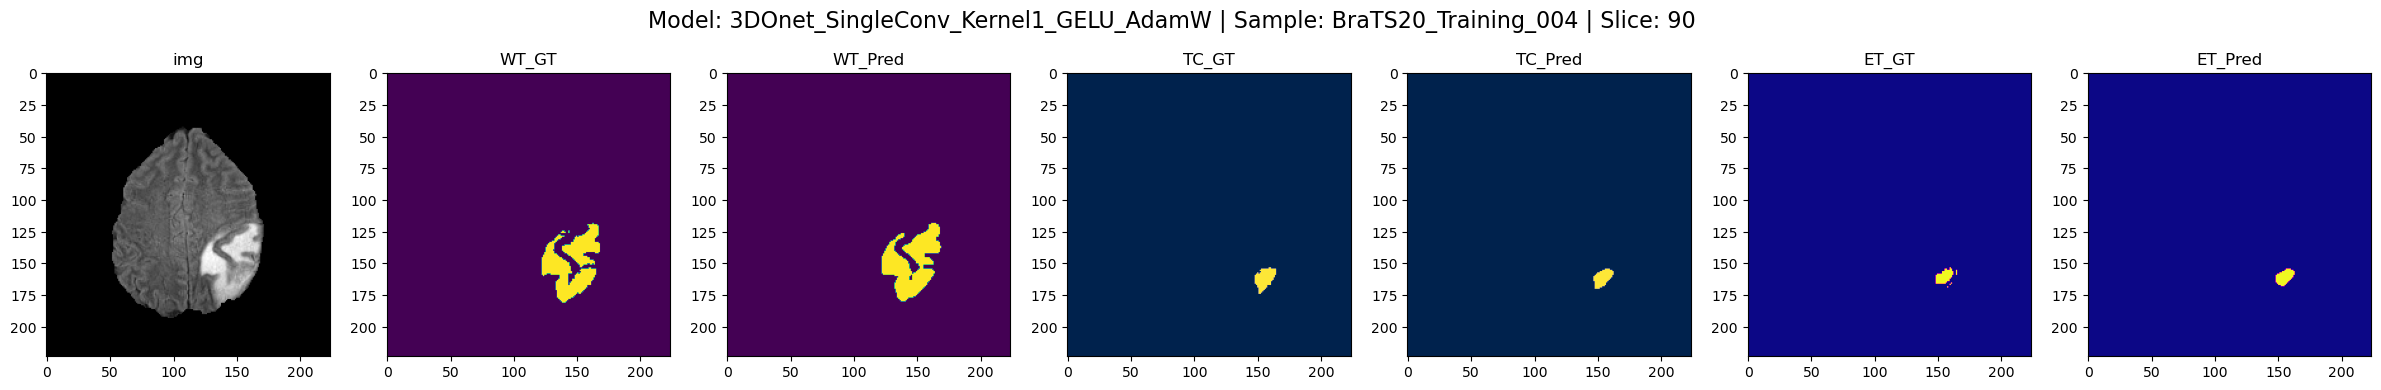

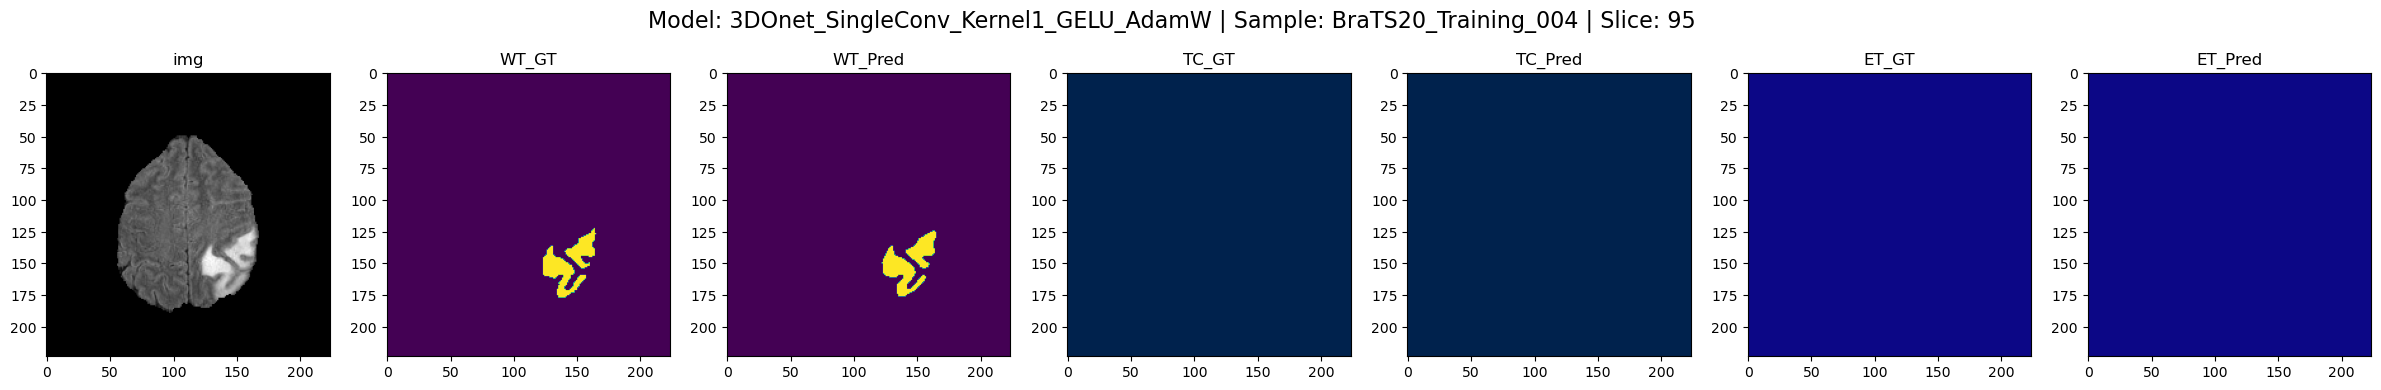

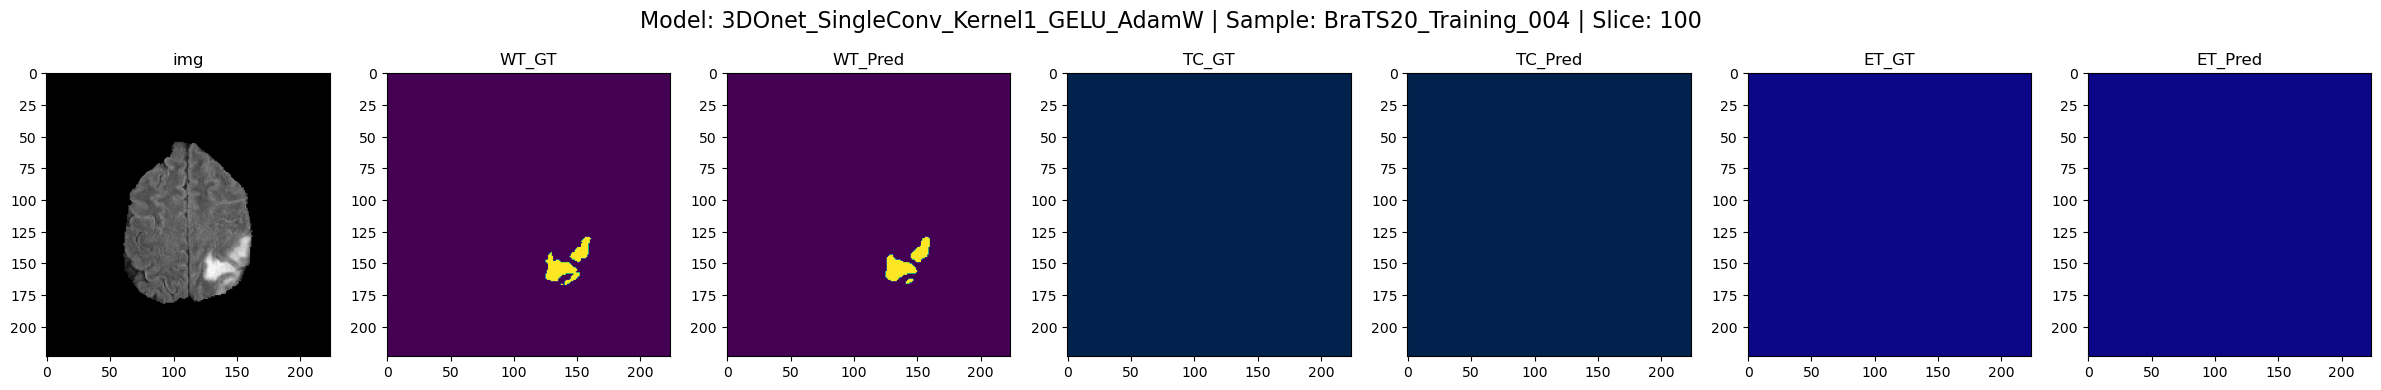

In [20]:
def evalSingle(target="BraTS20_Training_004", treshold=0.5):
  model_name = chooseModel()
  print(f"'{model_name}' selected for evaluation and visualisation")
  
  model = modelDict[model_name]
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
  checkpoint_path = None

  for filename in os.listdir(f"Logs/{model_name}"):
    if "your_best_model" in filename:
      checkpoint_path = f"Logs/{model_name}/{filename}"
      break

  try:
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    model.eval()
    print(f"{model_name} loaded with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
  except Exception as e:
    print(
        f"Error loading {model_name} with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
    print(e)
    return

  name, imgs, targets = None, None, None
  
  _, _, test_dataloader = get_dataloaders(
      dataset=BratsDataset, path_to_csv="./fold_data.csv", val_fold=0, test_fold=1, batch_size=1, do_resizing=True)
  
  print("Evaluating on test set...")
  start = datetime.now()
  dice_scores_per_classes, iou_scores_per_classes, ids = compute_scores_per_classes(
      model, test_dataloader, ['WT', 'TC', 'ET']
  )
  ids_df = pd.DataFrame(ids)
  ids_df.columns = ['Ids']

  dice_df = pd.DataFrame(dice_scores_per_classes)

  dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

  iou_df = pd.DataFrame(iou_scores_per_classes)
  iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
  val_metics_df = pd.concat([ids_df, dice_df, iou_df], axis=1, sort=True)
  val_metics_df = val_metics_df.loc[:, ['Ids',
                                        'WT dice', 'WT jaccard',
                                        'TC dice', 'TC jaccard',
                                        'ET dice', 'ET jaccard']]
  mean_metrics_df = val_metics_df.mean()
  val_metics_df.sort_values(by=["Ids"], inplace=True)
  val_metics_df = val_metics_df.reset_index(drop=True)
  colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']


  palette = sns.color_palette(colors, 6)

  fig, ax = plt.subplots(figsize=(12, 6))
  sns.barplot(x=mean_metrics_df.index,
              y=mean_metrics_df, palette=palette, ax=ax)
  ax.set_title(f"{model_name}'s Dice and Jaccard Coefficients from Test Set", fontsize=20)

  for idx, p in enumerate(ax.patches):
      percentage = '{:.1f}%'.format(100 * mean_metrics_df.values[idx])
      x = p.get_x() + p.get_width() / 2 - 0.15
      y = p.get_y() + p.get_height()
      ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")
  plt.show()
  print(
      f"Evaluation done! Inference time: {datetime.now() - start}.  Now proceeding to visualisation of predictions...")
  
  _, _, test_dataloader = get_dataloaders(
      dataset=BratsDataset, path_to_csv="./fold_data.csv", val_fold=0, test_fold=1, batch_size=1, do_resizing=True)

  for i, data in enumerate(test_dataloader):
    if data['Id'][0] == target:
      print("Target found: ", target)
      name, imgs, targets = data['Id'][0], data['image'], data['mask']
  

  

  with torch.no_grad():
    print("Predicting for: ", model_name)
    imgs, targets = imgs.to(device), targets.to(device)
    logits = model(imgs)
    probs = torch.sigmoid(logits)

    predictions = (probs >= treshold).float()
    predictions = predictions.cpu()
    targets = targets.cpu()

    img, gt, prediction = imgs.cpu(), targets, predictions

    img = img.squeeze()[0].cpu().detach().numpy()
    gt0 = gt[0][0].squeeze().cpu().detach().numpy()
    gt1 = gt[0][1].squeeze().cpu().detach().numpy()
    gt2 = gt[0][2].squeeze().cpu().detach().numpy()
    pred0 = prediction[0][0].squeeze().cpu().detach().numpy()
    pred1 = prediction[0][1].squeeze().cpu().detach().numpy()
    pred2 = prediction[0][2].squeeze().cpu().detach().numpy()

    for i in range(40, 100+1, 5):

      fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(
          1, 7, figsize=(30, 10))
      slice_w = i

      ax1.imshow(img[slice_w, :, :], cmap="gray")
      ax1.set_title(f'img')
      ax2.imshow(gt0[slice_w, :, :], cmap="viridis")
      ax2.set_title(f'WT_GT')
      ax3.imshow(pred0[slice_w, :, :], cmap="viridis")
      ax3.set_title(f'WT_Pred')
      ax4.imshow(gt1[slice_w, :, :], cmap="cividis")
      ax4.set_title(f'TC_GT')
      ax5.imshow(pred1[slice_w, :, :], cmap="cividis")
      ax5.set_title(f'TC_Pred')
      ax6.imshow(gt2[slice_w, :, :], cmap="plasma")
      ax6.set_title(f'ET_GT')
      ax7.imshow(pred2[slice_w, :, :], cmap="plasma")
      ax7.set_title(f'ET_Pred')
      # fig.tight_layout(rect=[0, 0.03, 1, 0.95])
      fig.suptitle(
          f'Model: {model_name} | Sample: {name} | Slice: {i}', y=0.7, fontsize=16)
      plt.show()
  return val_metics_df


# save_predictions_to_logs()
val_metics_df = evalSingle()


### Display accuracy for all test samples.

In [21]:
val_metics_df


,Ids,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
0,BraTS20_Training_004,0.954244,0.912493,0.915706,0.844518,8.669091e-01,7.650835e-01
1,BraTS20_Training_008,0.826692,0.704582,0.848335,0.736615,8.563686e-01,7.488152e-01
2,BraTS20_Training_017,0.924492,0.859587,0.873251,0.775018,7.922954e-01,6.560341e-01
3,BraTS20_Training_018,0.791145,0.654458,0.708999,0.549185,6.624632e-01,4.952860e-01
4,BraTS20_Training_025,0.912718,0.839449,0.941743,0.889899,8.646661e-01,7.615964e-01
5,BraTS20_Training_047,0.891280,0.803881,0.907625,0.830874,8.364911e-01,7.189383e-01
6,BraTS20_Training_061,0.834662,0.716241,0.898121,0.815081,7.550901e-01,6.065420e-01
7,BraTS20_Training_067,0.950661,0.905962,0.946853,0.899069,8.862110e-01,7.956722e-01
8,BraTS20_Training_074,0.830970,0.710821,0.528793,0.359428,5.585797e-01,3.875203e-01
9,BraTS20_Training_076,0.895498,0.810770,0.819874,0.694734,7.154744e-01,5.569950e-01
